# 3c) xarray

This tutorial is adapted in large part from the [xarray FAQ](http://xarray.pydata.org/en/stable/faq) and the [Earth and Environmental Data Science course's xarray lecture](https://earth-env-data-science.github.io/lectures/xarray/xarray.html). Also, part of this tutorial is based on the Python introduction from last year of André Jüling, created under the BSD 3-Clause License (https://github.com/AJueling/python_climate_physics).

We have already introduced NetCDF files and the NetCDF4 package. The latter is only used for reading and creating NetCDF files. There is also a "pandas-like" package for NetCDF files: __Xarray__ was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.) xarray builds on NetCDF4.

The first part of the tutorial will focus on working with Pandas, the second part on NetCDF4 and xarray. First, let's import the package

`import xarray as xr`

You can check wether pandas is alreay installed on your pc with the command

`conda list`

This gives an overview of all the packages that are installed. If you don't have pandas yet, install it with

`conda install xarray` or `pip install xarray` 

You can do this directly in the Notebook or in the terminal.

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### xarray Terminology

First we need to establish the basic concepts. Imagine ocean model output with temperature and salinity stored at (x,y,z,t).

Similar to pandas, there are two data structures available in xarray:
- `DataArray`: is single variable field, e.g. temperature that can be high dimensional at each point for several time steps.
- `Dataset`: holds several DataArrays, e.g. both the temperature and salinity fields. These DataArrays may be aligned, i.e. be located at the same points.

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values, e.g. temperature or salinity values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`, or `('lat', 'lon', 'time')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings), e.g. the locations in a spatial direction: 1 m, 2 m, 3 m, ... or in time: day 1, day 2, day 3, ...
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

## DataArray
We will first investigate a DataArray by creating one filled with random numbers:

In [5]:
da = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
da  # this produces a fancy html representation of the data

<xarray.DataArray (x: 2, y: 3)>
array([[ 1.15201934,  1.46856056,  0.95647433],
       [-0.97657036,  0.07170741, -0.5437077 ]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

We have generated a 2D array, assigned the names x and y to the two dimensions respectively and associated two coordinate labels ‘10’ and ‘20’ with the two locations along the x dimension. Notice not every dimension needs to have a coordinate.

These are the key properties of the DataArray:

In [6]:
print(da.values)
print(da.dims)
print(da.coords)
print(da.attrs)  # empty

[[ 1.15201934  1.46856056  0.95647433]
 [-0.97657036  0.07170741 -0.5437077 ]]
('x', 'y')
Coordinates:
  * x        (x) int64 10 20
{}


Xarray has built-in plotting, like pandas. We can modify these plots with extra matplotlib code.

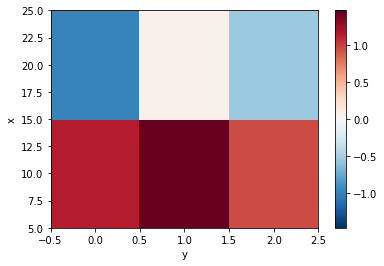

In [7]:
da.plot()  # notice the automatic labeling

Text(0.5,0,'some other x label')

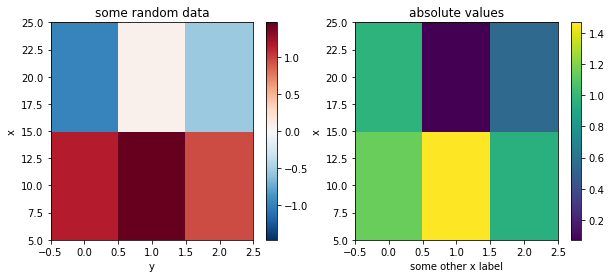

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
da.plot(ax=ax[0])
ax[0].set_title('some random data')
abs(da).plot(ax=ax[1])
ax[1].set_title('absolute values')
ax[1].set_xlabel('some other x label')

### Indexing

Indexing options are similar to what we have seen in NumPy and Pandas, but there are more options. Such as `sel` (=select) and `isel` (=integer select), in the first case you give a coordinate and in the second case an integer. What makes these options so useful, is that the values don't need to be exact, but you can tell Python to return the values closest.

With this label-based indexing, you don't have to know how an array is organized. You just need to know  the dimension name and the label we wish to index i.e. `data.sel(x=10)` works regardless of whether `x` is the first or second dimension of the array and regardless of whether 10 is the first or second element of `x`. We have already told xarray that `x` is the first dimension when we created `data`: xarray keeps track of this so we don’t have to.

In [8]:
# positional and by integer label, like numpy
print(da[0, :], '\n\n')

# loc or "location": positional and coordinate label, like pandas
print(da.loc[10], '\n\n')

# isel or "integer select":  by dimension name and integer label
print(da.isel(x=0), '\n\n')

# sel or "select": by dimension name and coordinate label
print(da.sel(x=10), '\n\n')

# the values do not need to be exact
# this is extremely handy for selecting the closest location, for example
print(da.sel(x=12, method='nearest'), '\n\n')

<xarray.DataArray (y: 3)>
array([1.15201934, 1.46856056, 0.95647433])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([1.15201934, 1.46856056, 0.95647433])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([1.15201934, 1.46856056, 0.95647433])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([1.15201934, 1.46856056, 0.95647433])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([1.15201934, 1.46856056, 0.95647433])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 




## Dataset

Now we move on to Datasets.

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : xarray.DataArray
    pandas.Dataframe  : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The `Dataset` constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

We can create a Dataset in [several ways](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html), here is one using a distionary with names and DataArrays:

In [14]:
# a simplified way to construct a dataset is to provide a dictionry with the names and DataArrays:
xr.Dataset({'data':da, 'data_squared':da**2})

<xarray.Dataset>
Dimensions:       (x: 2, y: 3)
Coordinates:
  * x             (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    data          (x, y) float64 1.152 1.469 0.9565 -0.9766 0.07171 -0.5437
    data_squared  (x, y) float64 1.327 2.157 0.9148 0.9537 0.005142 0.2956

### Open netCDF files
Opening netCDF files is a simple command with xarray: `open_dataset`

Let us first download some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset. This file was a bit big to upload to GitHub, so go to the [website](https://data.giss.nasa.gov/pub/gistemp/) and download (and unzip) `gistemp1200_ERSSTv5.nc.gz` manually.

In [9]:
ds = xr.open_dataset('data/gistemp1200_GHCNv4_ERSSTv5.nc')

Inspect the contents of this file by typing the name

In [10]:
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1700, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2021-09-12 09:48:48 by SBBX_to_nc 2.0 - ILAND=1200,...

Like pandas, xarray has built-in plot functions, which makes it easy to investigate the data. With the indexing options, we can easily plot the temperature anomaly on the first of june:

In [ ]:
ds.tempanomaly.sel(time='2020-06-01', method='nearest').plot()

## Creating netCDF files and saving them
Above we created the DataArray `da` which we can save with a single command as a netcdf file (this also works for DataSets):

In [17]:
da.to_netcdf('test.nc')

## Other data formats
Although netCDF is the de-facto standard in climate science, you may encounter other data formats:
##### GRIB
##### ZARR
##### HDF
##### binary
Most of these can be opened with xarray, others you may need to combine into a DataSet/DataArray object yourself.

### Other netCDF packages and software
[Iris](http://scitools.org.uk/iris/) (supported by the UK Met office) provides similar tools for in- memory manipulation of labeled arrays, aimed specifically at weather and climate data needs. Indeed, the Iris Cube was direct inspiration for xarray’s DataArray. xarray and Iris take very different approaches to handling metadata: Iris strictly interprets CF ('Climate and Forecast') conventions. Iris particularly shines at mapping, thanks to its integration with Cartopy.

[UV-CDAT](http://uvcdat.llnl.gov/) is another Python library that implements in-memory netCDF-like variables and tools for working with climate data.

[Panoply](https://www.giss.nasa.gov/tools/panoply/) is a netCDF, HDF and GRIB data viewer.

## Operations
We can apply many of the same operations on xarray DataArrays as with pandas Series/DataFrames and numpy ndarrays.

### Broadcasting

Broadcasting arrays in NumPy can be a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting

In [18]:
lon_times_lat = ds.lon * ds.lat
lon_times_lat

<xarray.DataArray (lon: 180, lat: 90)>
array([[ 15931.,  15573.,  15215., ..., -15215., -15573., -15931.],
       [ 15753.,  15399.,  15045., ..., -15045., -15399., -15753.],
       [ 15575.,  15225.,  14875., ..., -14875., -15225., -15575.],
       ...,
       [-15575., -15225., -14875., ...,  14875.,  15225.,  15575.],
       [-15753., -15399., -15045., ...,  15045.,  15399.,  15753.],
       [-15931., -15573., -15215., ...,  15215.,  15573.,  15931.]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

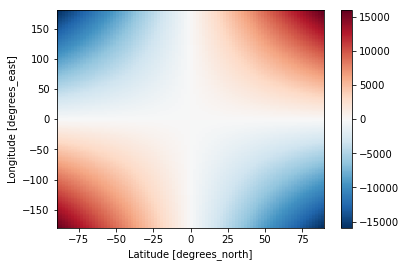

In [19]:
lon_times_lat.plot()

### Reductions

Just like in NumPy, we can reduce xarray DataArrays along any number of axes:

In [20]:
ds.tempanomaly.mean(axis=0).dims

('lat', 'lon')

In [21]:
ds.tempanomaly.mean(axis=1).dims

('time', 'lon')

You see that it is much easier to see over what you are taking the average than it was in NumPy! You can also the dimensions to state over what you want to average:


In [22]:
ds_zonal_mean = ds.mean(dim='lon')
ds_zonal_mean

<xarray.Dataset>
Dimensions:      (lat: 90, time: 1700, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2021-09-01
    tempanomaly  (time, lat) float32 nan nan nan nan nan ... 0.59 0.59 0.59 0.59

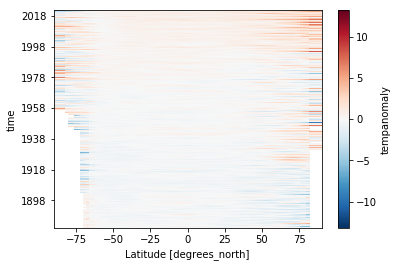

In [23]:
ds_zonal_mean.tempanomaly.plot()

You can also perform a reduction and plot in 1 line of code, such as we've done here of the standard deviation:

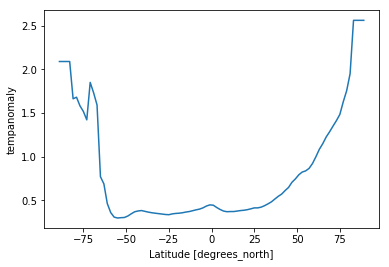

In [24]:
ds_zonal_mean.tempanomaly.std('time').plot()

### Rolling
Similar to the `resample` method we used in the previous exercise, we can calculate the running mean to smooth signals. Here, we use a moving average filter of 5 years.

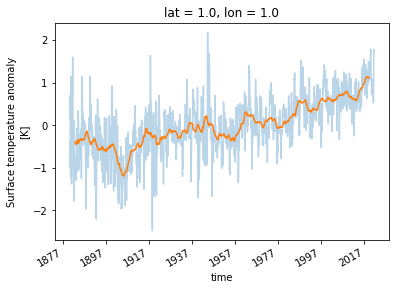

In [42]:
example = ds.sel({'lat':0, 'lon':0}, method='nearest').tempanomaly
ds_rolling = example.rolling(time=5*12, center=True).mean()
example.plot(alpha=.3)
ds_rolling.plot()  # notice the missing values at either end


### Access the time
You can access time properties with the `dt` accessor.

In [26]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 1700)>
array([1880, 1880, 1880, ..., 2021, 2021, 2021])
Coordinates:
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-08-15

## <span style="color:blue">Exercises</span>

1. Create a dataset with two (10x10x10) DataArrays `A` and `B` with dimensions `lat`, `lon`, `time` and some sensible coordinates. Use `pd.date_range` function to create time coordinates (use the `pd.date_range?` to find out how to use it). Create a `source` attribute that mentions who created the Dataset. Save the dataset as `test2.nc`.

2. Select the time series of temperature anomalies of your birth place (with the latitude and longitude) from the GISSTEMP dataset `ds` that we briefly inspected before.  Use the `resample(time='A').mean()` to create annual means.  Calculate the temperature mean between 1970 and 2000 and use it as a reference. Create the iconic warming stripes graphic. Use [this tutorial](https://matplotlib.org/matplotblog/posts/warming-stripes/) as an inspiration.
<img src="figures/3b2.png" width="800">

3. Calculate the standard deviation of the monthly and annual temperatures GISSTEMP dataset `ds` and create two maps thereof in a single figure.

4. Calculate the linear trend of a temperature time series above in [$^\circ$C/century].

## <span style="color:green">Solutions</span>

In [28]:
# 1. Create a dataset with two (10x10x10) DataArrays `A` and `B` 
# with dimensions `lat`, `lon`, `time` and some sensible coordinates.
# Use the `pd.date_range` function to create time coordinates 
# (use the `pd.date_range?` to find out how to use it).
# Create a `source` attribute that mentions who created the Dataset.
# Save the dataset as `test2.nc`.

nlat, nlon, ntime = 10, 10, 10
lats = np.linspace(-90, 90, nlat)
lons = np.linspace(0, 360, nlon)
times = pd.date_range(start='2020-01-01', end='2020-09-28', periods=ntime)
data_A = np.random.rand(nlat, nlon, ntime)
data_B = np.random.rand(nlat, nlon, ntime)
ds_ = xr.Dataset(data_vars={'A':(('lat','lon','time'), data_A),
                           'B':(('lat','lon','time'), data_B),
                          },
                coords={'lat':lats, 'lon':lons, 'time':times}
               )
ds_.attrs['source'] = 'created by André Jüling'
print(ds_)
ds_.to_netcdf('test2.nc')

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, time: 10)
Coordinates:
  * lat      (lat) float64 -90.0 -70.0 -50.0 -30.0 -10.0 ... 30.0 50.0 70.0 90.0
  * lon      (lon) float64 0.0 40.0 80.0 120.0 160.0 ... 240.0 280.0 320.0 360.0
  * time     (time) datetime64[ns] 2020-01-01 2020-01-31T02:40:00 ... 2020-09-28
Data variables:
    A        (lat, lon, time) float64 0.696 0.706 0.6349 ... 0.3062 0.8331
    B        (lat, lon, time) float64 0.6828 0.08318 0.05861 ... 0.08741 0.6763
Attributes:
    source:   created by André Jüling


<xarray.DataArray 'tempanomaly' ()>
array(0.3930833, dtype=float32)
Coordinates:
    lat      float32 51.0
    lon      float32 3.0


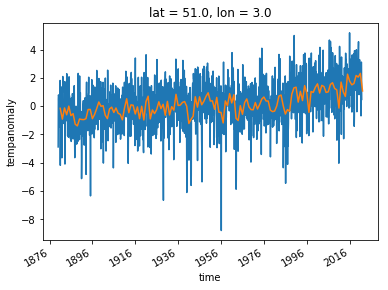

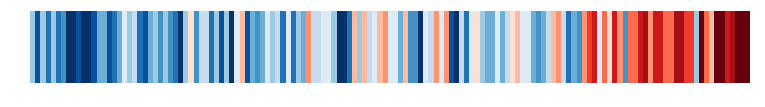

In [45]:
# 2. Select the time series of temperature anomalies of you birth place 
# from the GISSTEMP dataset `ds` that we briefly inspected before.
# Use the `resample(time='A').mean()` to create annual means.
# Calculate the temperature mean between 1970 and 2000 and use it as a reference.
# Create the iconic warming stripes graphic.
# Use this tutorial as an inspiration: https://matplotlib.org/matplotblog/posts/warming-stripes/
timeseries = ds.tempanomaly.sel({'lat':51.4485683, 'lon':3.5703873}, method='nearest')
reference = timeseries.sel({'time':slice('1970-01-01','2000-01-01')}).mean()
print(reference)
annual = timeseries.resample(time='A').mean()
timeseries.plot()
annual.plot()

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(10, 1))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
col = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(1880, 2020 + 1)])
col.set_array(annual.values)
col.set_cmap(cmap)
col.set_clim(reference-1.5, reference+1.5)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(1880,2020+1)
plt.savefig('figures/3b2')

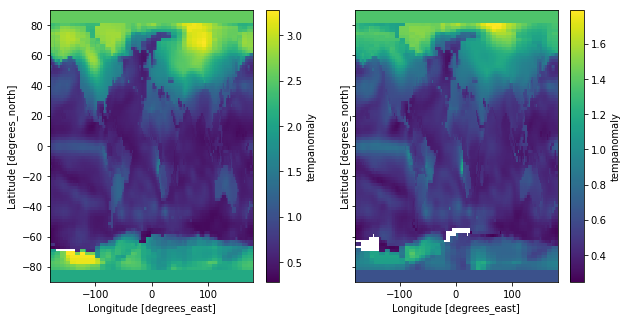

In [29]:
# 3. Calculate the standard deviation of the monthly and annual temperatures 
# and create two maps thereof in a single figure.
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ds.tempanomaly.std('time').plot(ax=ax[0])
ds.tempanomaly.rolling(time=12, center=True).mean().std('time').plot(ax=ax[1])

In [31]:
# 4. Calculate the linear trend of a temperature time series above in [$^\circ$C/century].
pf = np.polyfit(example.time.dt.year+example.time.dt.month/12, example, deg=1)
print(f'The temperature increase is {pf[0]*100:.1f} K/century')

The temperature increase is 1.0 K/century
